<a href="https://colab.research.google.com/github/gna-rus/EXP_analysis/blob/main/EXP_From_ELECTRO_to_OPTIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задача:
Предсказать оптические параметры, зная исключительно электрические параметры транзисторов

In [90]:
import pandas as pd
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')

from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

pd.options.mode.copy_on_write = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
df = pd.read_excel('/content/drive/MyDrive/for_EXP/Merge_RC_TFT_and_OPTIC.xlsx')
df = df.rename(columns={"Unnamed: 0": "my_id"})


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39000 entries, 0 to 38999
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   my_id                        39000 non-null  int64  
 1   index                        39000 non-null  int64  
 2   Lot-panel                    39000 non-null  object 
 3   PEM                          39000 non-null  object 
 4   S_Design                     18000 non-null  float64
 5   Measurement Structure        39000 non-null  object 
 6   Capasitance                  18000 non-null  float64
 7   Sheet resistance             12000 non-null  float64
 8   VIA resistance               6000 non-null   float64
 9   Resistance                   3000 non-null   float64
 10  Description                  39000 non-null  object 
 11  X                            39000 non-null  int64  
 12  Y                            39000 non-null  int64  
 13  TFT             

In [181]:
# Эта и следующая строка нужна для сравнения значений в одном лоте но в разных PEM
df[(df['Lot-panel'] == 'EXP80-1') & (df['PEM'] == 'X9-Y19')].sample(5)

,my_id,index,Lot-panel,PEM,S_Design,Measurement Structure,Capasitance,Sheet resistance,VIA resistance,Resistance,Description,X,Y,TFT,Von,Hyst,Id(Von+3V),SS,Ioff,Cni,Cox,Num_of_square,res_mean_on_glass_SD1-E-CD,err_result_SD1-E-CD,line_SD1_E_CD,result_SD1-E-CD,res_mean_on_glass_VI1-E-CD,result_VI1-E-CD,err_result_VI1-E-CD,line_VI1_E_CD,res_mean_on_glass_ME1-E-CD,result_ME1-E-CD,err_result_ME1-E-CD,line_ME1_E_CD,res_mean_on_glass_IGZO-E-CD,result_IGZO-E-CD,err_result_IGZO-E-CD,line_IGZO_E_CD,X_square,Y_square
5,46961,13506,EXP80-1,X9-Y19,0.0,VIA SD-GATE,0.0,0.0,2.0,0.0,Reference 4 +SiNx 200nm,87244,224836,Nominal,-0.900748,0.200385,8.070060e-07,0.347302,1.408571e-13,0.0,0.0,"85000,190000",4.52292,0.148,4.652,0.0,6.01892,1.0,1.077,6.023,4.81804,0.0,0.471,4.629,5.062455,0.0,0.037,5.463,85000,190000
7,46963,13506,EXP80-1,X9-Y19,0.0,VIA SD-GATE,0.0,0.0,2.0,0.0,Reference 4 +SiNx 200nm,87244,224836,Nominal,-0.900748,0.200385,8.070060e-07,0.347302,1.408571e-13,0.0,0.0,"85000,190000",4.52292,0.148,4.652,0.0,6.01892,0.0,1.077,6.023,4.81804,0.0,0.471,4.629,5.062455,1.0,0.037,5.463,85000,190000
0,46956,13505,EXP80-1,X9-Y19,0.0,VIA SD-SEMIA,0.0,0.0,735.0,0.0,Reference 4 +SiNx 200nm,87244,224836,Nominal,-0.900748,0.200385,8.070060e-07,0.347302,1.408571e-13,0.0,0.0,"85000,190000",4.52292,0.148,4.652,1.0,6.01892,0.0,1.077,6.023,4.81804,0.0,0.471,4.629,5.062455,0.0,0.037,5.463,85000,190000
2,46958,13505,EXP80-1,X9-Y19,0.0,VIA SD-SEMIA,0.0,0.0,735.0,0.0,Reference 4 +SiNx 200nm,87244,224836,Nominal,-0.900748,0.200385,8.070060e-07,0.347302,1.408571e-13,0.0,0.0,"85000,190000",4.52292,0.148,4.652,0.0,6.01892,0.0,1.077,6.023,4.81804,1.0,0.471,4.629,5.062455,0.0,0.037,5.463,85000,190000
44,47000,13516,EXP80-1,X9-Y19,22000.0,Capacitor SD-GATE,30.6,0.0,0.0,0.0,Reference 4 +SiNx 200nm,87244,224836,Nominal,-0.900748,0.200385,8.070060e-07,0.347302,1.408571e-13,0.0,0.0,"85000,190000",4.52292,0.148,4.652,1.0,6.01892,0.0,1.077,6.023,4.81804,0.0,0.471,4.629,5.062455,0.0,0.037,5.463,85000,190000


In [182]:
df[(df['Lot-panel'] == 'EXP80-1') & (df['PEM'] == 'X35-Y35')].sample(5)

,my_id,index,Lot-panel,PEM,S_Design,Measurement Structure,Capasitance,Sheet resistance,VIA resistance,Resistance,Description,X,Y,TFT,Von,Hyst,Id(Von+3V),SS,Ioff,Cni,Cox,Num_of_square,res_mean_on_glass_SD1-E-CD,err_result_SD1-E-CD,line_SD1_E_CD,result_SD1-E-CD,res_mean_on_glass_VI1-E-CD,result_VI1-E-CD,err_result_VI1-E-CD,line_VI1_E_CD,res_mean_on_glass_ME1-E-CD,result_ME1-E-CD,err_result_ME1-E-CD,line_ME1_E_CD,res_mean_on_glass_IGZO-E-CD,result_IGZO-E-CD,err_result_IGZO-E-CD,line_IGZO_E_CD,X_square,Y_square
1030,45958,13299,EXP80-1,X35-Y35,43950.0,Capacitor GATE-SEMIA,28.6,0.0,0.0,0.0,Reference 4 +SiNx 200nm,347224,128816,Nominal,-1.00088,0.00002,7.729915e-07,0.345693,1.461693e-13,0.0,0.0,"350000,100000",4.52292,0.573,4.227,0.0,6.01892,0.0,0.873,6.227,4.81804,1.0,0.182,4.918,5.062455,0.0,0.254,5.246,350000,100000
1008,45936,13255,EXP80-1,X35-Y35,0.0,Line SD,0.0,0.2,0.0,0.0,Reference 4 +SiNx 200nm,347224,128816,Nominal,-1.00088,0.00002,7.729915e-07,0.345693,1.461693e-13,0.0,0.0,"350000,100000",4.52292,0.573,4.227,1.0,6.01892,0.0,0.873,6.227,4.81804,0.0,0.182,4.918,5.062455,0.0,0.254,5.246,350000,100000
1031,45959,13299,EXP80-1,X35-Y35,43950.0,Capacitor GATE-SEMIA,28.6,0.0,0.0,0.0,Reference 4 +SiNx 200nm,347224,128816,Nominal,-1.00088,0.00002,7.729915e-07,0.345693,1.461693e-13,0.0,0.0,"350000,100000",4.52292,0.573,4.227,0.0,6.01892,0.0,0.873,6.227,4.81804,0.0,0.182,4.918,5.062455,1.0,0.254,5.246,350000,100000
1017,45945,13278,EXP80-1,X35-Y35,11000.0,Capacitor GATE-SEMIA,31.9,0.0,0.0,0.0,Reference 4 +SiNx 200nm,347224,128816,Nominal,-1.00088,0.00002,7.729915e-07,0.345693,1.461693e-13,0.0,0.0,"350000,100000",4.52292,0.573,4.227,0.0,6.01892,1.0,0.873,6.227,4.81804,0.0,0.182,4.918,5.062455,0.0,0.254,5.246,350000,100000
1037,45965,13301,EXP80-1,X35-Y35,22000.0,Capacitor SD-GATE,31.2,0.0,0.0,0.0,Reference 4 +SiNx 200nm,347224,128816,Nominal,-1.00088,0.00002,7.729915e-07,0.345693,1.461693e-13,0.0,0.0,"350000,100000",4.52292,0.573,4.227,0.0,6.01892,1.0,0.873,6.227,4.81804,0.0,0.182,4.918,5.062455,0.0,0.254,5.246,350000,100000


# **HeatMap через phik**


In [94]:
! pip install phik
import phik
# Phik полезен при нелинейных взаимосвязях
from phik.report import plot_correlation_matrix
from phik import report

In [168]:
col_only_electro = ['my_id', 'index', 'Lot-panel', 'PEM', 'S_Design',
       'Measurement Structure', 'Capasitance', 'Sheet resistance',
       'VIA resistance', 'Resistance', 'Description', 'X', 'Y', 'TFT', 'Von',
       'Hyst', 'Id(Von+3V)', 'SS', 'Ioff', 'Cni', 'Cox']

col_only_optic = ['res_mean_on_glass_SD1-E-CD', 'err_result_SD1-E-CD', 'line_SD1_E_CD',
       'result_SD1-E-CD', 'res_mean_on_glass_VI1-E-CD', 'result_VI1-E-CD',
       'err_result_VI1-E-CD', 'line_VI1_E_CD', 'res_mean_on_glass_ME1-E-CD',
       'result_ME1-E-CD', 'err_result_ME1-E-CD', 'line_ME1_E_CD',
       'res_mean_on_glass_IGZO-E-CD', 'result_IGZO-E-CD',
       'err_result_IGZO-E-CD', 'line_IGZO_E_CD']


X = ['Lot-panel', 'PEM', 'Measurement Structure',
     'Von', 'Id(Von+3V)', 'SS', 'Ioff', 'Cni', 'Cox',
     'Capasitance', 'Sheet resistance', 'VIA resistance', 'Resistance']

cat_features = ['Lot-panel', 'PEM', 'Measurement Structure']

Y_line_SD1_E_CD = ['line_SD1_E_CD']
Y_line_VI1_E_CD = ['line_VI1_E_CD']
Y_line_ME1_E_CD = ['line_ME1_E_CD']
Y_line_IGZO_E_CD = ['line_IGZO_E_CD']


list1 = ['line_SD1_E_CD', 'line_VI1_E_CD', 'line_ME1_E_CD', 'line_IGZO_E_CD']

In [96]:
for i in df:
  df[i] = df[i].fillna(0)


interval columns not set, guessing: ['Von', 'Id(Von+3V)', 'SS', 'Ioff', 'Cni', 'Cox', 'line_SD1_E_CD', 'line_VI1_E_CD', 'line_ME1_E_CD', 'line_IGZO_E_CD']


<Axes: >

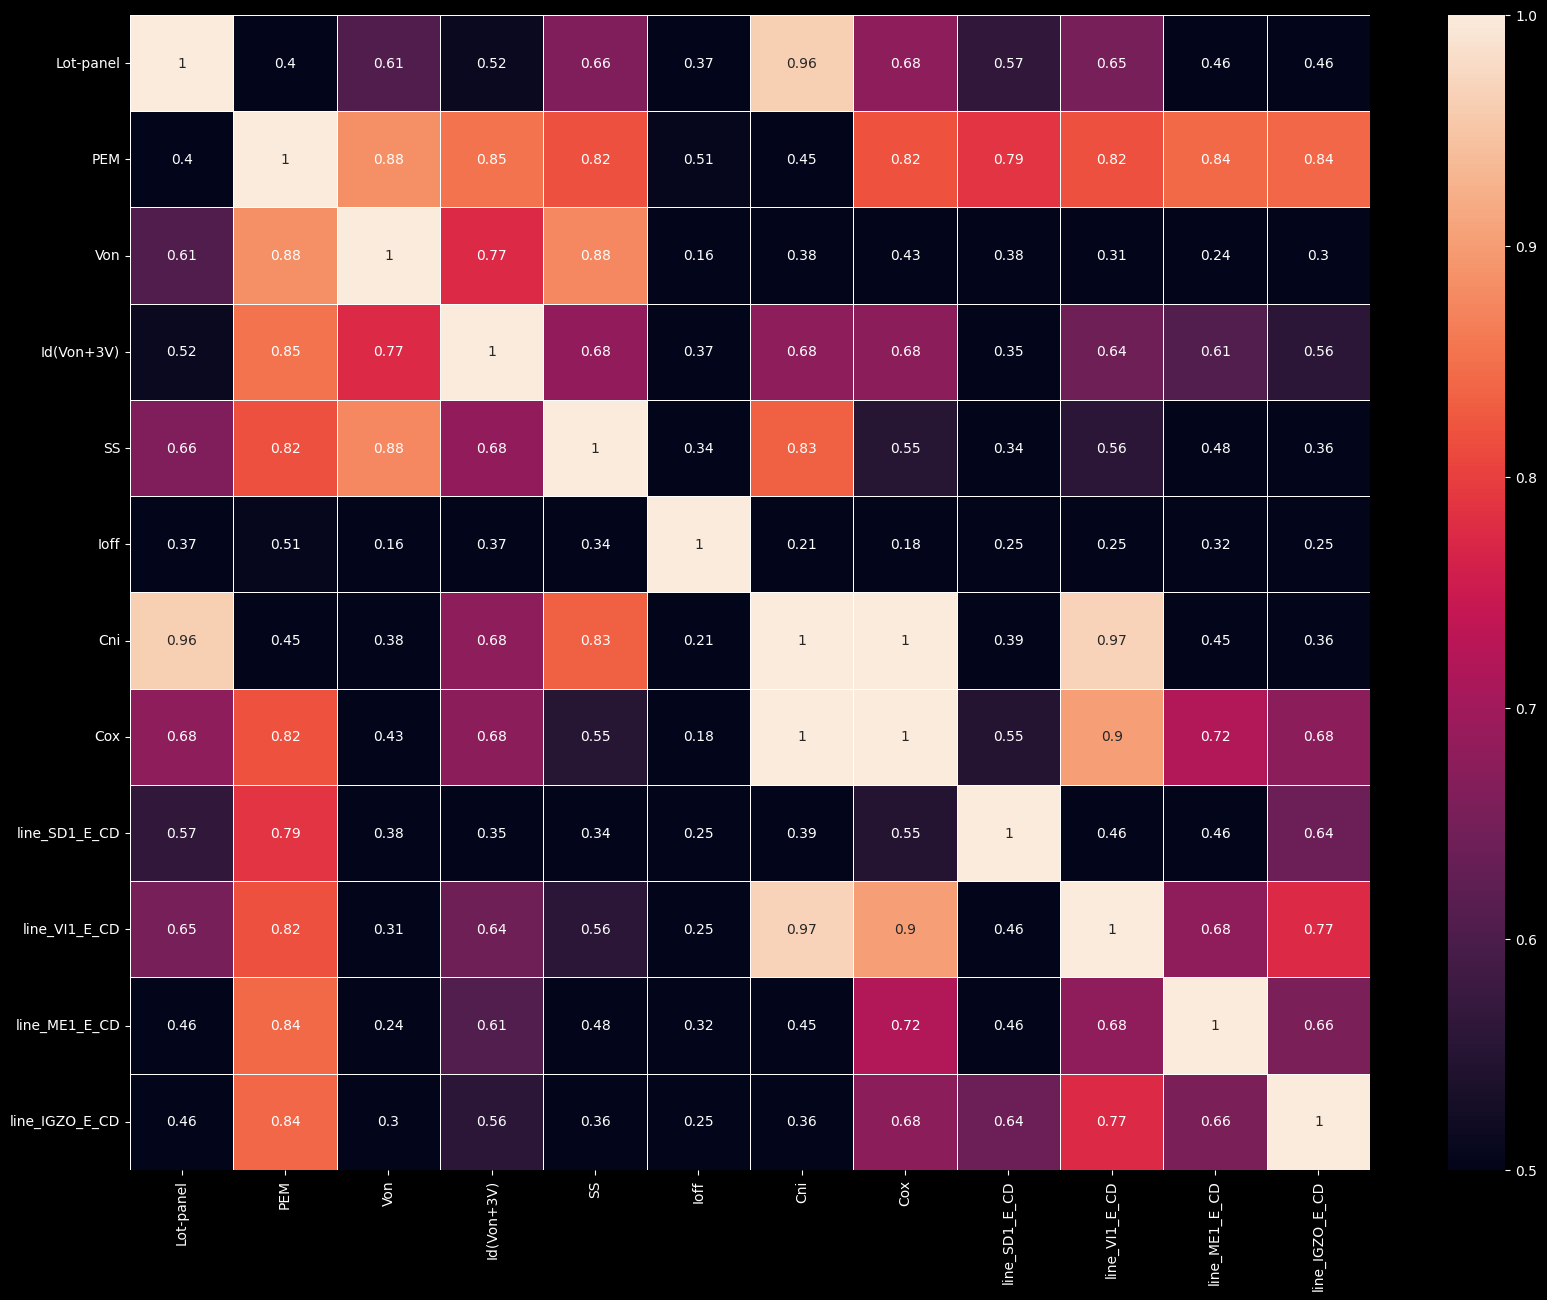

In [115]:
listX_Y = X.copy() + list1

train_corr = df[listX_Y].phik_matrix()
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(train_corr, annot=True, linewidths=0.5, vmin=0.5)

# **Настройка CatBoost**

In [ ]:
! pip install catboost

In [ ]:
from catboost import CatBoostRegressor
# CatBoostRegressor - если надо предсказать какое-то значение
# CatBoostRanker - используется для ранжирования

In [103]:
# Создаю выборки для настройки модели (использую только данные с Description == Reference 4 +SiNx 200nm	из первичных данных)
small_df, train = train_test_split(df,train_size=0.01,random_state=42)
train, val = train_test_split(df,train_size=0.8,random_state=42)
# val, test = train_test_split(test,train_size=0.5,random_state=42)
# train - данные для основного обучения
# test - проверочные данные
# val - данные для финального теста (нужна для того чтобы избежать переобучения)

In [169]:
# Создаю модель CatBoost (провожу настройку)
parameter = CatBoostRegressor(cat_features = cat_features,
                          learning_rate = 0.5,
                          iterations=500,
                          depth = 6,
                          early_stopping_rounds = 200,
                          eval_metric = 'MAPE',
                          verbose=100)
# learning_rate =  - коэфициент влияющий на качество обучения каждой итерации (надо настроить так чтобы лучшим обучением было в районе 900, но не больше 999 (из 1000))
# early_stopping_rounds - количество не лучших раундов по достижению которого подряд обучение завершится
# eval_metric='MAPE'/ RMSE / Quantile - задаю метрику для создания модели (читай документацию, метрик много)
# verbose = 100 - выводить каждую 100 итерацию качества
# random_seed = 42, depth = 6, learning_rate = 0.5,

In [170]:
# Передаю в модель обучающие данные line_SD1_E_CD
model_line_SD1_E_CD = parameter.copy()
model_line_SD1_E_CD.fit(train[X],train[Y_line_SD1_E_CD], eval_set=(val[X],val[Y_line_SD1_E_CD]))
# model.fit(train[X_test],train[Y], verbose=False)

0:	learn: 0.1301675	test: 0.1368341	best: 0.1368341 (0)	total: 63.6ms	remaining: 31.7s
100:	learn: 0.0037904	test: 0.0028177	best: 0.0028177 (100)	total: 3.19s	remaining: 12.6s
200:	learn: 0.0020944	test: 0.0014527	best: 0.0014527 (200)	total: 5.63s	remaining: 8.38s
300:	learn: 0.0015924	test: 0.0010736	best: 0.0010736 (300)	total: 7.89s	remaining: 5.22s
400:	learn: 0.0013133	test: 0.0008841	best: 0.0008808 (395)	total: 10.2s	remaining: 2.51s
499:	learn: 0.0011545	test: 0.0007970	best: 0.0007970 (499)	total: 13.4s	remaining: 0us

bestTest = 0.0007969813574
bestIteration = 499



In [171]:
# Передаю в модель обучающие данные line_VI1_E_CD
model_line_VI1_E_CD = parameter.copy()
model_line_VI1_E_CD.fit(train[X],train[Y_line_VI1_E_CD], eval_set=(val[X],val[Y_line_VI1_E_CD]))

0:	learn: 0.0674626	test: 0.0677478	best: 0.0677478 (0)	total: 44.9ms	remaining: 22.4s
100:	learn: 0.0036528	test: 0.0032938	best: 0.0032938 (100)	total: 4.11s	remaining: 16.2s
200:	learn: 0.0023417	test: 0.0018923	best: 0.0018923 (200)	total: 6.56s	remaining: 9.76s
300:	learn: 0.0017770	test: 0.0013879	best: 0.0013879 (300)	total: 8.89s	remaining: 5.88s
400:	learn: 0.0014946	test: 0.0010984	best: 0.0010982 (399)	total: 11.2s	remaining: 2.77s
499:	learn: 0.0013530	test: 0.0009461	best: 0.0009439 (495)	total: 14.4s	remaining: 0us

bestTest = 0.0009438866791
bestIteration = 495

Shrink model to first 496 iterations.


In [172]:
# Передаю в модель обучающие данные line_ME1_E_CD
model_line_ME1_E_CD = parameter.copy()
model_line_ME1_E_CD.fit(train[X],train[Y_line_ME1_E_CD], eval_set=(val[X],val[Y_line_ME1_E_CD]))

0:	learn: 0.0335217	test: 0.0337460	best: 0.0337460 (0)	total: 53.8ms	remaining: 26.8s
100:	learn: 0.0011259	test: 0.0008291	best: 0.0008291 (100)	total: 3.93s	remaining: 15.5s
200:	learn: 0.0005857	test: 0.0003666	best: 0.0003666 (200)	total: 6.19s	remaining: 9.21s
300:	learn: 0.0004337	test: 0.0002505	best: 0.0002505 (300)	total: 8.37s	remaining: 5.54s
400:	learn: 0.0003549	test: 0.0001871	best: 0.0001871 (400)	total: 10.7s	remaining: 2.64s
499:	learn: 0.0003004	test: 0.0001520	best: 0.0001519 (498)	total: 13s	remaining: 0us

bestTest = 0.0001519354476
bestIteration = 498

Shrink model to first 499 iterations.


In [173]:
# Передаю в модель обучающие данные line_IGZO_E_CD
model_line_IGZO_E_CD = parameter.copy()
model_line_IGZO_E_CD.fit(train[X],train[Y_line_IGZO_E_CD], eval_set=(val[X],val[Y_line_IGZO_E_CD]))

0:	learn: 0.0335665	test: 0.0329759	best: 0.0329759 (0)	total: 39.8ms	remaining: 19.9s
100:	learn: 0.0013466	test: 0.0009554	best: 0.0009554 (100)	total: 4.81s	remaining: 19s
200:	learn: 0.0007709	test: 0.0004615	best: 0.0004615 (200)	total: 7.31s	remaining: 10.9s
300:	learn: 0.0005553	test: 0.0002906	best: 0.0002906 (300)	total: 9.56s	remaining: 6.32s
400:	learn: 0.0004695	test: 0.0002423	best: 0.0002423 (400)	total: 11.7s	remaining: 2.9s
499:	learn: 0.0003980	test: 0.0001864	best: 0.0001864 (499)	total: 19.5s	remaining: 0us

bestTest = 0.0001863526277
bestIteration = 499



# **Предсказание**

In [179]:
# Делаю предсказание по созданной моделе. В Модель загружается df без целевого параметра, а выводится список искомого параметра по каждой строчке
def prediction_of_parameters(df_pop, small_df, X, Y, name):
  num = 1 # начальная точка (срока в таблице) для сравнения реальных и предсказанных зныечений
  offset = 50 # размер выборки для получения погрешности
  size = 10 # количество выводимых в консоль эл-тов


  res = df_pop.predict(small_df[X]) # передача данных в модель для предсказаний
  res_list = list(res)[(num):(num+offset)] # предсказание
  real_value = small_df.iloc[(num):(num+offset)] # реальные значения

  real_value_for_print = []

  for i in real_value[num:num+size][Y[0]]:
    real_value_for_print.append(i)

  mean_error = mean_absolute_error(real_value[Y[0]], res_list)
  mean_error_per = mean_absolute_percentage_error(real_value[Y[0]], res_list)

  print(f'{name}:')
  print(f"Абсолютное значение ошибки", f'{mean_error}'.rjust(35, "_"))
  print("Абсолютное значение ошибки в процентах", f'{mean_error_per}'.rjust(23, "_"))
  print(mean_error, "    ",mean_error_per)
  print()
  print(f"Предсказание: {res_list[num:num+size]}", " ", f'Реальное значение: {real_value_for_print}', sep='\n')
  print("_"*130)


prediction_of_parameters(model_line_SD1_E_CD, small_df, X, Y_line_SD1_E_CD, 'line_SD1_E_CD')
prediction_of_parameters(model_line_VI1_E_CD, small_df, X, Y_line_VI1_E_CD, 'line_VI1_E_CD')
prediction_of_parameters(model_line_ME1_E_CD, small_df, X, Y_line_ME1_E_CD, 'line_ME1_E_CD')
prediction_of_parameters(model_line_IGZO_E_CD, small_df, X, Y_line_IGZO_E_CD, 'line_IGZO_E_CD')

line_SD1_E_CD:
Абсолютное значение ошибки _______________0.003698187770030099
Абсолютное значение ошибки в процентах __0.0006363832854859883
0.003698187770030099      0.0006363832854859883

Предсказание: [5.227459397631357, 4.860413512971727, 6.4909831111995615, 4.840853760833201, 6.080969607902457, 6.192458387927791, 6.0790621361465, 5.85426617768101, 5.353786488051264, 5.504669838071996]
 
Реальное значение: [5.229, 4.862, 6.493, 4.846, 6.08, 6.193, 6.08, 5.88, 5.353, 5.502]
__________________________________________________________________________________________________________________________________
line_VI1_E_CD:
Абсолютное значение ошибки ______________0.0035066804022371658
Абсолютное значение ошибки в процентах ___0.000607174922530645
0.0035066804022371658      0.000607174922530645

Предсказание: [4.252993720661314, 5.36043862552311, 6.559848107601988, 5.496996068899494, 6.271227322476199, 5.066619689667082, 6.265351699914432, 6.6585185250406305, 5.134022854984158, 6.262484861